<a target="_blank" href="https://colab.research.google.com/github/jbirky/vplanet_tutorials/blob/main/tutorials/1_introduction_to_stellar.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 0. Installations

First make sure you have installed the package vplanet using either
```
pip install vplanet
```
or from source from github. If you're working through this notebook on colab, install the packages locally from source using the following lines:



In [1]:
!git clone https://github.com/VirtualPlanetaryLaboratory/vplanet.git

import subprocess
subprocess.call(["python setup.py develop"], cwd="vplanet", shell=True)

Cloning into 'vplanet'...
remote: Enumerating objects: 37193, done.
remote: Counting objects: 100% (12555/12555), done.
remote: Compressing objects: 100% (2199/2199), done.
remote: Total 37193 (delta 10368), reused 12357 (delta 10201), pack-reused 24638
Receiving objects: 100% (37193/37193), 163.50 MiB | 34.41 MiB/s, done.
Resolving deltas: 100% (27234/27234), done.


0

Restart the kernel after installations:

In [ ]:
import os
os._exit(00)

Import packages:

In [1]:
import sys
sys.path.append("vplanet")
import vplanet

import subprocess
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['text.usetex'] = False
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16

# Create a directory to store our simulation configuration files
import os
temp_dir = "infile_templates"
if not os.path.exists(temp_dir):
  os.mkdir(temp_dir)

### 1. Setting up infile templates

`VPLANET` operates using `infiles` which specify all of the parameters settings used in your simulation.

For the case of modeling the stellar evolution of an individual star, we will have two files:
- vpl file `vpl.in` - configurations for the system (including numerical integration settings, output options, units, as well as system age)
- body file `star.in` - represents the star, sets the stellar parameters, and specifies which stellar models are used for stellar evolution (also magnetic braking, not shown in this case)

To run `VPLANET` in python we'll copy these [infiles](https://github.com/VirtualPlanetaryLaboratory/vplanet/tree/main/examples/StellarEvol) to strings here (I've added some annotations for each of the variables):

In [2]:
# System input file template
vpl_file = """#
sSystemName               system
iVerbose                  0           # Verbosity level
bOverwrite                1           # Allow file overwrites?
saBodyFiles               star.in     # list infile names of all body files
bDoLog                    1           # Write a log file?
iDigits                   6           # Maximum number of digits to right of decimal
dMinValue                 1e-10       # Minimum value of eccentricity/obliquity
bDoForward                1           # Perform a forward evolution?
bVarDt                    1           # Use variable timestepping?
dEta                      0.01        # Coefficient for variable timestepping

# Input/Output Units
# Units specified in the primary input file are propagated into the bodies
sUnitMass                 solar       # Options: gram, kg, Earth, Neptune, Jupiter, solar
sUnitLength               m           # Options: cm, m, km, Earth, Jupiter, solar, AU
sUnitTime                 year        # Options: sec, day, year, Myr, Gyr
sUnitAngle                deg         # Options: deg, rad

dStopTime                 1.0e9       # Final age which the system will be evolved to [sUnitTime]
dOutputTime               1.0e6       # Output timesteps (finer timesteps will take longer) [sUnitTime]
"""

# Star input file template
body_file = """#
sName                     star        # body name
saModules                 stellar     # VPLanet module(s) used
sStellarModel             baraffe     # stellar model grid (currently only baraffe+2015 grids)
dMass                     1.0         # stellar mass [sUnitMass]
dAge                      5e6         # age at which stellar grids are initialized (age we assume star has formed) [sUnitTime]

# output evolution parameters
saOutputOrder Time Luminosity Radius Temperature
"""

Now let's save these infiles to our folder `infile_templates/stellar/baraffe`:

In [3]:
# Create subdirectory stellar/baraffe to save this example
example_baraffe = os.path.join(temp_dir, "stellar/baraffe")
if not os.path.exists(example_baraffe):
  os.makedirs(example_baraffe)

# Write vpl_file to vpl.in
with open(os.path.join(example_baraffe, "vpl.in"), "w") as file:
  print(vpl_file, file=file)

# Write body_file to star.in
with open(os.path.join(example_baraffe, "star.in"), "w") as file:
  print(body_file, file=file)

### 2. Running simulations through command line

This model can be run through command line by executing `vplanet vpl.in` in the directory where we saved the infiles:

In [4]:
subprocess.call("vplanet vpl.in", cwd=example_baraffe, shell=True)

0

**Plotting results**: In our body file we specified that we wanted `vplanet` to track the evolution of the following parameters:
```
saOutputOrder Time Luminosity Radius Temperature
```
We can make a quick plot of these output variables using the `auto_plot` function of the package `vplot`:

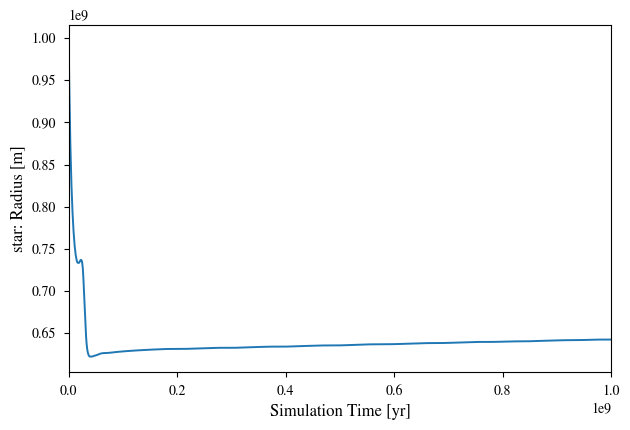

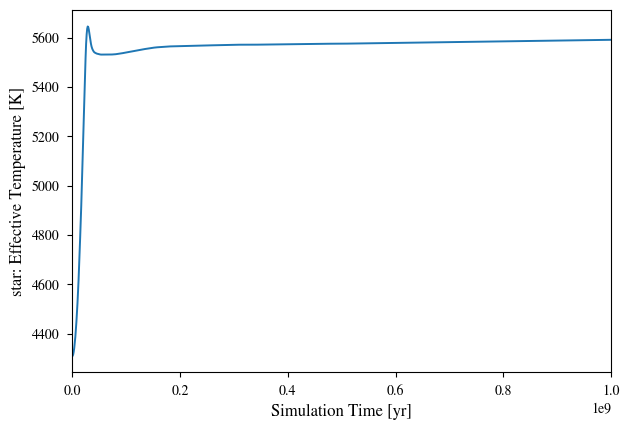

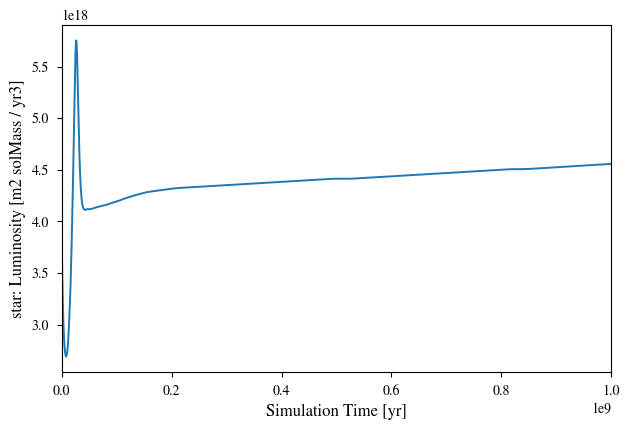

In [5]:
import vplot as vpl
vpl.auto_plot(example_baraffe)

We can retrieve and manipulate the outputs using the `vplanet` function `get_output`. The returned arrays will be in the same order as we specified in the `saOutputOrder` of our body file (`star.in`)

In [6]:
output = vplanet.get_output(example_baraffe)
output.star[:]

[<VPLANETQuantity [0.00e+00, 1.00e+06, 2.00e+06, ..., 9.98e+08, 9.99e+08,
                   1.00e+09] yr>,
 <VPLANETQuantity [3.878056e+18, 3.490268e+18, 3.219360e+18, ...,
                   4.557011e+18, 4.557337e+18, 4.557668e+18] m2 solMass / yr3>,
 <VPLANETQuantity [9.975614e+08, 9.462657e+08, 9.066883e+08, ...,
                   6.421678e+08, 6.421742e+08, 6.421812e+08] m>,
 <VPLANETQuantity [4309.980416, 4310.017791, 4315.677498, ..., 5591.866241,
                   5591.897808, 5591.929944] K>]

We can convert the units of our output arrays using astropy units, for example:

In [7]:
sim_time = output.star[:][0].to(u.yr)
sim_luminosity = output.star[:][1].to(u.Lsun)

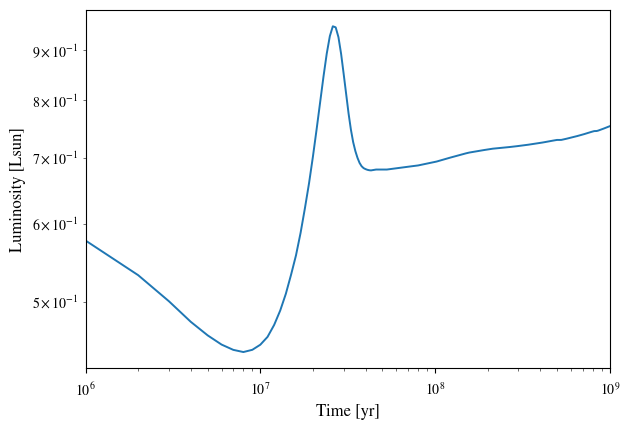

In [8]:
plt.plot(sim_time, sim_luminosity)
plt.ylabel("Luminosity [Lsun]")
plt.xlabel("Time [yr]")
plt.xscale("log")
plt.yscale("log")
plt.show()

### 3. How to add input variables and output variables

**[Part A]** say we also want to model the XUV luminosity of our star.

`vplanet` includes the Ribas+2005 empirical model for XUV evolution of low-mass, which is parameterized by a broken power law:
\begin{align}
\frac{L_{\rm XUV}}{L_{\rm bol}} = \left\{
				\begin{array}{lcr}
					f_\mathrm{sat} &\ & t \leq t_\mathrm{sat} \\
					f_\mathrm{sat}\left(\frac{t}{t_\mathrm{sat}}\right)^{-\beta_\mathrm{XUV}} &\ & t > t_\mathrm{sat}
				\end{array}
				\right.
\end{align}
This model assumes that young (more active) stars exhibit a "saturated" level of XUV luminosity relative to bolometric (total luminosity), which then decays exponentially over time, after a "saturation time". Here $L_{\rm bol}$ is the bolometric luminosity [$L_\odot$], $L_{\rm XUV}$ is the XUV luminosity [$L_\odot$], $f_\mathrm{sat} = \log_{10}(L_{\rm XUV}/L_{\rm bol})$ is the saturation ratio, $t_\mathrm{sat}$ is the duration of saturation phase [Gyr], $\beta_\mathrm{XUV}$ is the exponential decay rate of $L_{\rm XUV}$ after saturation, and $t$ is the evolution time [Gyr].

To have `vplanet` compute the XUV lumiosity evolution using this model, we'll add the following input variables to our body infiles (since they are properties of the star, they will go in `star.in`):
```
dSatXUVFrac            
dSatXUVTime              
dXUVBeta   
```
And we will also add the following variable to our output variables in `saOutputOrder`:
```
LXUVTot
```





In [9]:
# System input file template
vpl_file = """#
sSystemName               system
iVerbose                  0           # Verbosity level
bOverwrite                1           # Allow file overwrites?
saBodyFiles               star.in     # list infile names of all body files
bDoLog                    1           # Write a log file?
iDigits                   6           # Maximum number of digits to right of decimal
dMinValue                 1e-10       # Minimum value of eccentricity/obliquity
bDoForward                1           # Perform a forward evolution?
bVarDt                    1           # Use variable timestepping?
dEta                      0.01        # Coefficient for variable timestepping

# Input/Output Units
# Units specified in the primary input file are propagated into the bodies
sUnitMass                 solar       # Options: gram, kg, Earth, Neptune, Jupiter, solar
sUnitLength               m           # Options: cm, m, km, Earth, Jupiter, solar, AU
sUnitTime                 year        # Options: sec, day, year, Myr, Gyr
sUnitAngle                deg         # Options: deg, rad

dStopTime                 1.0e9       # Final age which the system will be evolved to [sUnitTime]
dOutputTime               1.0e6       # Output timesteps (finer timesteps will take longer) [sUnitTime]
"""

# Star input file template
body_file = """#
sName                     star        # body name
saModules                 stellar     # VPLanet module(s) used
sStellarModel             baraffe     # stellar model grid (currently only baraffe+2015 grids)
dMass                     1.0         # stellar mass [sUnitMass]
dAge                      5e6         # age at which stellar grids are initialized (age we assume star has formed) [sUnitTime]

dSatXUVFrac               1.0e-3      # fsat = initial Lxuv / Lbol [dimensionless ratio]
dSatXUVTime               1.0e8       # tsat = saturation time [sUnitTime]
dXUVBeta                  1.0         # beta = exponential decay rate [dimensionless]

# output evolution parameters
saOutputOrder Time Luminosity Radius Temperature LXUVTot
"""

We can now execute this model as before, and plot our new output variable:

In [10]:
# Create subdirectory stellar/baraffe to save this example
example_baraffe_ribas = os.path.join(temp_dir, "stellar/baraffe_ribas")
if not os.path.exists(example_baraffe_ribas):
  os.makedirs(example_baraffe_ribas)

# Write vpl_file to vpl.in
with open(os.path.join(example_baraffe_ribas, "vpl.in"), "w") as file:
  print(vpl_file, file=file)

# Write body_file to star.in
with open(os.path.join(example_baraffe_ribas, "star.in"), "w") as file:
  print(body_file, file=file)

In [11]:
subprocess.call("vplanet vpl.in", cwd=example_baraffe_ribas, shell=True)

0

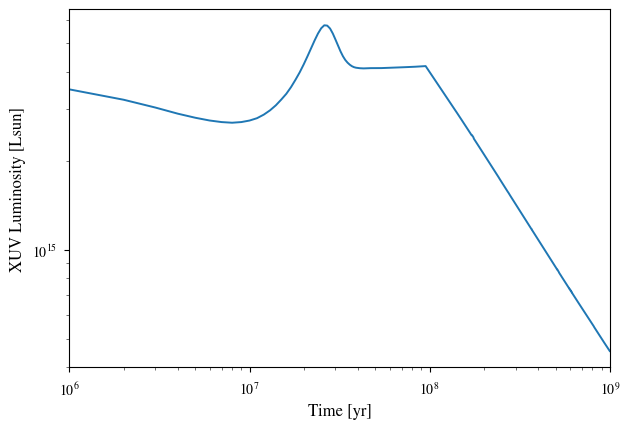

In [12]:
output = vplanet.get_output(example_baraffe_ribas)

plt.plot(output.star[:][0], output.star[:][-1])
plt.ylabel("XUV Luminosity [Lsun]")
plt.xlabel("Time [yr]")
plt.xscale("log")
plt.yscale("log")
plt.show()

**[Part B]** say we also want to model the rotational evolution of our star according to gyrochrnology models.

`vplanet` includes several implementations of magnetic braking laws which govern the rotational evolution of the star:
* [Reiners & Mohanty [2012]](https://ui.adsabs.harvard.edu/abs/2012ApJ...746...43R/abstract)
* [Repetto & Nelemans [2014]](https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..542R/abstract>)
* [Matt et al. [2015]](https://ui.adsabs.harvard.edu/abs/2015ApJ...799L..23M/abstract)

To add a magnetic braking model to our simulation we will add the following inputs:
```
sMagBrakingModel
dRotPeriod
```
where the variable `sMagBrakingModel` specifies which magnetic braking model to use (options: `matt`, `reiners`, `skumanich`), and the variable `dRotPeriod` specifies the initial condition rotation period of the star. In this example we'll set the initial rotation period to 10 days (or 0.027378508 years since that's the unit we've set for `sUnitTime`).

We will also add the output variable
```
RotPer
```
so that we can track the rotation period evolution.





In [18]:
# System input file template
vpl_file = """#
sSystemName               system
iVerbose                  0           # Verbosity level
bOverwrite                1           # Allow file overwrites?
saBodyFiles               star.in     # list infile names of all body files
bDoLog                    1           # Write a log file?
iDigits                   6           # Maximum number of digits to right of decimal
dMinValue                 1e-10       # Minimum value of eccentricity/obliquity
bDoForward                1           # Perform a forward evolution?
bVarDt                    1           # Use variable timestepping?
dEta                      0.01        # Coefficient for variable timestepping

# Input/Output Units
# Units specified in the primary input file are propagated into the bodies
sUnitMass                 solar       # Options: gram, kg, Earth, Neptune, Jupiter, solar
sUnitLength               m           # Options: cm, m, km, Earth, Jupiter, solar, AU
sUnitTime                 year        # Options: sec, day, year, Myr, Gyr
sUnitAngle                deg         # Options: deg, rad

dStopTime                 1.0e9       # Final age which the system will be evolved to [sUnitTime]
dOutputTime               1.0e6       # Output timesteps (finer timesteps will take longer) [sUnitTime]
"""

# Star input file template
body_file = """#
sName                     star        # body name
saModules                 stellar     # VPLanet module(s) used
sStellarModel             baraffe     # stellar model grid (currently only baraffe+2015 grids)
sMagBrakingModel          matt        # magnetic braking model (opt: matt, reiners, skumanich)
dMass                     1.0         # stellar mass [sUnitMass]
dAge                      5e6         # age at which stellar grids are initialized (age we assume star has formed) [sUnitTime]

dSatXUVFrac               1.0e-3      # fsat = initial Lxuv / Lbol [dimensionless ratio]
dSatXUVTime               1.0e8       # tsat = saturation time [sUnitTime]
dXUVBeta                  1.0         # beta = exponential decay rate [dimensionless]

dRotPeriod                0.027378508 # initial rotation period [sUnitTime]

# output evolution parameters
saOutputOrder Time Luminosity Radius Temperature LXUVTot RotPer
"""

In [19]:
# Create subdirectory stellar/baraffe to save this example
example_baraffe_ribas_matt = os.path.join(temp_dir, "stellar/baraffe_ribas_matt")
if not os.path.exists(example_baraffe_ribas_matt):
  os.makedirs(example_baraffe_ribas_matt)

# Write vpl_file to vpl.in
with open(os.path.join(example_baraffe_ribas_matt, "vpl.in"), "w") as file:
  print(vpl_file, file=file)

# Write body_file to star.in
with open(os.path.join(example_baraffe_ribas_matt, "star.in"), "w") as file:
  print(body_file, file=file)

In [20]:
subprocess.call("vplanet vpl.in", cwd=example_baraffe_ribas_matt, shell=True)

0

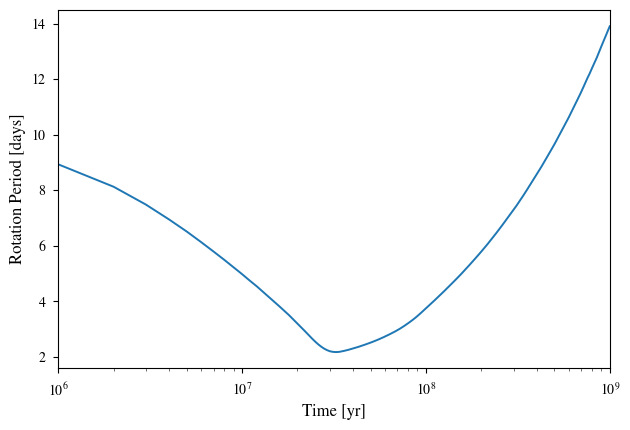

In [21]:
output = vplanet.get_output(example_baraffe_ribas_matt)

sim_time = output.star[:][0].to(u.yr)
sim_prot = output.star[:][-1].to(u.day)

plt.plot(sim_time, sim_prot)
plt.ylabel("Rotation Period [days]")
plt.xlabel("Time [yr]")
plt.xscale("log")
plt.show()

### 4. Varying simulation parameters (manually)

Repeat step 3, this time experimenting with different values of input parameters:
```
dMass
dAge
dSatXUVFrac            
dSatXUVTime              
dXUVBeta  
dRotPeriod
```
Also see what output parameters you can add to `saOutputOrder`. For a description of available output options for each `vplanet` model, see the [documentation here](https://virtualplanetarylaboratory.github.io/vplanet/help.html). You can also open up the log file for one of the simulations we've run, which should show a list of variables like this. For example, the file `infile_templates/stellar/baraffe_ribas/system.log` should contain a list that looks something like this:

```
---- FINAL SYSTEM PROPERTIES ----
(Age) System Age [sec]: 3.171539e+16
(Time) Simulation Time [sec]: 3.155760e+16
(TotAngMom) Total Angular Momentum [kg*m^2/sec]: 2.906215e+43
(TotEnergy) Total System Energy [kg*m^2/sec^2]: -1.576439e+41
(PotEnergy) Body's non-orbital Potential Energy [kg*m^2/sec^2]: -2.465543e+41
(KinEnergy) Body's non-orbital Kinetic Energy [kg*m^2/sec^2]: 2.374104e+35
(DeltaTime) Average Timestep Over Last Output Interval [sec]: 2.979043e+08

----- BODY: star ----
Active Modules: STELLAR
Module Bit Sum: 65
Color: 000000
(Mass) Mass [kg]: 1.988416e+30
(Radius) Radius [m]: 6.421812e+08
(RadGyra) Radius of Gyration/Moment of Inertia Constant []: 0.290802
(RotAngMom) Rotational Angular Momentum [kg*m^2/sec]: 1.814568e+41
(RotVel) Rotational Velocity [m/sec]: 1680.405360
(BodyType) Type of Body (0 == planet) []: 0.000000
(RotRate) Rotational Frequency [/sec]: 2.616715e-06
(RotPer) Rotational Period [sec]: 2.401173e+06
(Density) Average Density [kg/m^3]: 1792.445051
(HZLimitDryRunaway) Semi-major axis of Dry Runaway HZ Limit [m]: 1.175737e+11
(HZLimRecVenus) Recent Venus HZ Limit [m]: 9.761750e+10
(HZLimRunaway) Runaway Greenhouse HZ Limit [m]: 1.279327e+11
(HZLimMoistGreenhouse) Moist Greenhouse HZ Limit [m]: 1.291631e+11
(HZLimMaxGreenhouse) Maximum Greenhouse HZ Limit [m]: 2.207654e+11
(HZLimEarlyMars) Early Mars HZ Limit [m]: 2.408656e+11
(Instellation) Orbit-averaged INcident STELLar radiATION [kg*m^2/sec^2/(m^2*sec)]: -1.000000
(CriticalSemiMajorAxis) Holman & Wiegert (1999) P-type Critical Semi-major Axis [m]: -1.000000
(LXUVTot) Total XUV Luminosity [kg*m^2/sec^2/(m^2*sec)]: 2.869274e+22
(LostEnergy) Body's Total Lost Energy [kg*m^2/sec^2]: 8.891018e+40
(LostAngMom) Lost Angular Momentum due to Magnetic Braking [kg*m^2/sec]: 2.888069e+43
----- STELLAR PARAMETERS (star)------
(Luminosity) Luminosity [kg*m^2/sec^3]: 2.883620e+26
(LXUVStellar) Base X-ray/XUV Luminosity [kg*m^2/sec^3]: 2.869274e+22
(Temperature) Effective Temperature [K]: 5591.929944
(LXUVFrac) Fraction of luminosity in XUV []: 9.950249e-05
(RossbyNumber) Rossby Number []: 1.774299
(DRotPerDtStellar) Time Rate of Change of Rotation Period in STELLAR []: 2.092177e-11
Output Order: Time[year] Luminosity[Msun*m^2/year^3] Radius[m] Temperature[K] LXUVTot[Msun*m^2/year^2/(m^2*year)]
Grid Output Order:
```
Parameters listed in parenthesis can be added to the `saOutputOrder`.





In [22]:
# System input file template
vpl_file = """#
sSystemName               system
iVerbose                  0           # Verbosity level
bOverwrite                1           # Allow file overwrites?
saBodyFiles               star.in     # list infile names of all body files
bDoLog                    1           # Write a log file?
iDigits                   6           # Maximum number of digits to right of decimal
dMinValue                 1e-10       # Minimum value of eccentricity/obliquity
bDoForward                1           # Perform a forward evolution?
bVarDt                    1           # Use variable timestepping?
dEta                      0.01        # Coefficient for variable timestepping

# Input/Output Units
# Units specified in the primary input file are propagated into the bodies
sUnitMass                 solar       # Options: gram, kg, Earth, Neptune, Jupiter, solar
sUnitLength               m           # Options: cm, m, km, Earth, Jupiter, solar, AU
sUnitTime                 year        # Options: sec, day, year, Myr, Gyr
sUnitAngle                deg         # Options: deg, rad

dStopTime                 1.0e9       # Final age which the system will be evolved to [sUnitTime]
dOutputTime               1.0e6       # Output timesteps (finer timesteps will take longer) [sUnitTime]
"""

# Star input file template
body_file = """#
sName                     star        # body name
saModules                 stellar     # VPLanet module(s) used
sStellarModel             baraffe     # stellar model grid (currently only baraffe+2015 grids)
sMagBrakingModel          matt        # magnetic braking model (opt: matt, reiners, skumanich)
dMass                     1.0         # stellar mass [sUnitMass]
dAge                      5e6         # age at which stellar grids are initialized (age we assume star has formed) [sUnitTime]

dSatXUVFrac               1.0e-3      # fsat = initial Lxuv / Lbol [dimensionless ratio]
dSatXUVTime               1.0e8       # tsat = saturation time [sUnitTime]
dXUVBeta                  1.0         # beta = exponential decay rate [dimensionless]

dRotPeriod                0.027378508 # initial rotation period [sUnitTime]

# output evolution parameters
saOutputOrder Time Luminosity Radius Temperature LXUVTot RotPer
"""

**Task**: make modifications to the template above by subsituting different input parameter values, then execute and plot your results. Also try comparing different simulations in the same plot!

In [ ]:
[your code goes here...]

**Task**: How does the "habitable zone" vary around stars of different masses? See what this looks like for different planetary conditions from [Kopparapu+2013](https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/meta) by adding these variables to your `saOutputOrder`:
```
HZLimitDryRunaway
HZLimRecVenus
HZLimRunaway
HZLimMoistGreenhouse
HZLimMaxGreenhouse
HZLimEarlyMars  
```



In [ ]:
[your code goes here...]